This notebook simulates fluorescent melt curves predicted from NUPACK.

Yuxi, April 2022

# Load stuffs

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
80.98% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
31.22% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


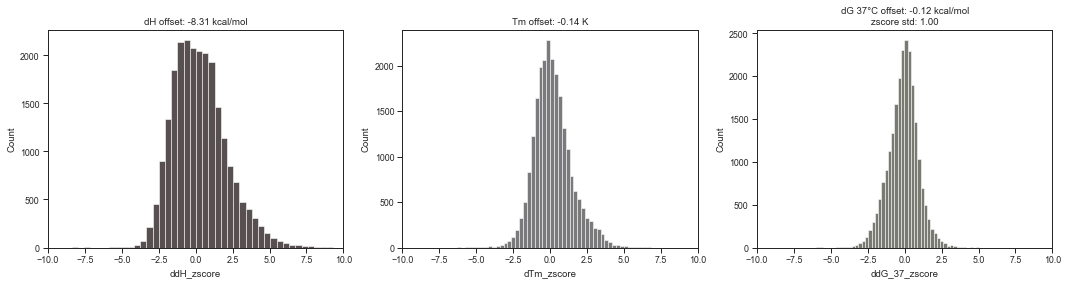

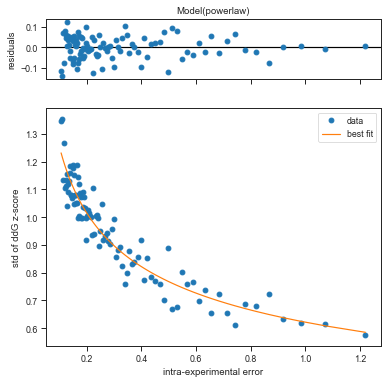

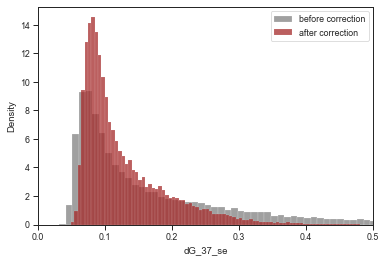

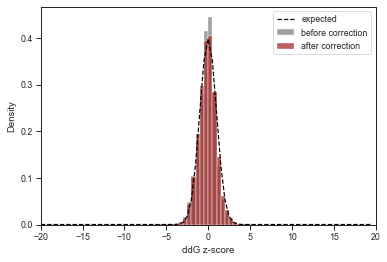

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct

from nnn import util, fileio, processing, plotting, motif_fit, simulation
from nnn.arraydata import ErrorAdjust, ArrayData

import warnings
warnings.filterwarnings("ignore")

annotation = fileio.read_annotation('./data/annotation/nnnlib2b_annotation_20220329.tsv')
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv',
                      learn_error_adjust_from=('r1', 'r2'))
revdata = ArrayData(replicate_df=replicate_df.iloc[3,:],
                   annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv')
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv')

arr = arraydata.data.join(arraydata.annotation).query('pair_prob > 0.5')
for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
    arr[f'd{param}'] = util.get_ddX(arr, param, 'ConstructType')
arr['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(arr, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

salt = saltdata.data.join(saltdata.annotation).query('pair_prob > 0.5')
for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
    salt[f'd{param}'] = util.get_ddX(salt, param, 'ConstructType')
salt['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(salt, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
salt['ddG_37_NUPACK_150mM'] = util.get_ddX(salt, 'dG_37_NUPACK_150mM', 'ConstructType')
salt['scaffold'] = salt.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

# Distance in nt

In [18]:
from nnn import simulation

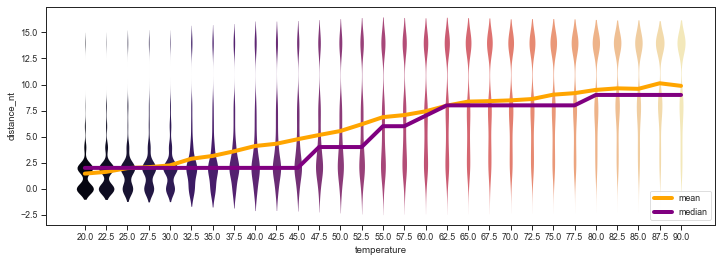

In [23]:
seq = 'AAATAGAAATATTT'
T = np.arange(20, 92.5, 2.5)
simulation.plot_nupack_curve_distance(seq, num_sample=1000, sodium=0.15, T=T)

Let's find the function from nt distance to fluorescence.

In [45]:
r1 = arraydata.get_replicate_data('r2')
r1 = r1.join(annotation)

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [46]:
repeat_series = r1.query('ConstructType == "RepeatControls"')
repeat_series['length'] = repeat_series.RefSeq.apply(len)
dangle_5p = annotation.query('ConstructType=="strong_stem_var_5prime_dangleAlen"')

In [47]:
repeat_series.RefSeq

SEQID
REPC01                           ACAC
REPC11162                        TTTC
REPC11163                    TTTCTTTC
REPC121                        AACAAC
REPC12173                        TGTG
REPC12174                      TGTGTG
REPC12175                    TGTGTGTG
REPC12183    TGTGTGTGTGTGTGTGTGTGTGTG
REPC13193                      TTGTTG
REPC14206                    TTTGTTTG
REPC14208            TTTGTTTGTTTGTTTG
REPC15216                        TATA
REPC15217                      TATATA
REPC15223          TATATATATATATATATA
REPC15224        TATATATATATATATATATA
REPC15225      TATATATATATATATATATATA
REPC16236                      TTATTA
REPC16237                   TTATTATTA
REPC17248                        TTTA
REPC17249                    TTTATTTA
REPC17250                TTTATTTATTTA
REPC17251            TTTATTTATTTATTTA
REPC18258                        AGGA
REPC20278                       ACCCA
REPC233                          AAAC
REPC234                      AAACAAAC
REPC34

In [49]:
repeat_series

,Green12_20.0_norm,Green12_20.0_norm_std,Green13_22.5_norm,Green13_22.5_norm_std,Green14_25.0_norm,Green14_25.0_norm_std,Green15_27.5_norm,Green15_27.5_norm_std,Green16_30.0_norm,Green16_30.0_norm_std,...,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,pair_prob,dG_37_NUPACK_150mM,dG_37_NUPACK_75mM,dG_37_ensemble,dG_37_ensemble_75mM,dG_37_ensemble_150mM,length
SEQID,,,,,,,,,,,,,,,,,,,,,
REPC01,0.218919,0.404261,0.266081,0.296202,0.276838,0.219795,0.293307,0.434778,0.321520,0.550246,...,-0.000000,....,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,4
REPC11162,0.110036,0.245138,0.183485,0.306174,0.164818,0.288129,0.217243,0.233430,0.239610,0.258471,...,-0.000000,....,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,4
REPC11163,0.440452,0.558253,0.474133,0.410225,0.515605,0.428933,0.512318,0.427228,0.593052,0.453117,...,-0.000000,........,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,8
REPC121,0.305354,0.980785,0.391946,0.487725,0.456510,0.522025,0.443832,0.487095,0.501850,0.647831,...,-0.000000,......,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,6
REPC12173,0.144465,0.241565,0.254230,0.148904,0.245367,0.183438,0.232010,0.232732,0.260795,0.228130,...,-0.000000,....,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,4
REPC12174,0.278114,0.235839,0.359493,0.277222,0.345059,0.195406,0.377638,0.637187,0.439850,0.687979,...,-0.000000,......,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,6
REPC12175,0.423380,0.393972,0.486212,0.385469,0.489988,0.386996,0.534603,0.443187,0.577958,0.403826,...,-0.000000,........,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,8
REPC12183,0.509936,0.450178,0.616159,0.429072,0.535197,0.390522,0.650100,0.371404,0.663700,0.373509,...,-0.000000,........................,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,24
REPC13193,0.238586,0.231572,0.303896,0.245038,0.319832,0.259485,0.341179,0.308962,0.377425,0.288321,...,-0.000000,......,0.0,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,6


In [59]:
conds = [c for c in repeat_series.columns if c.endswith('_norm')]

In [61]:
len(conds)

17

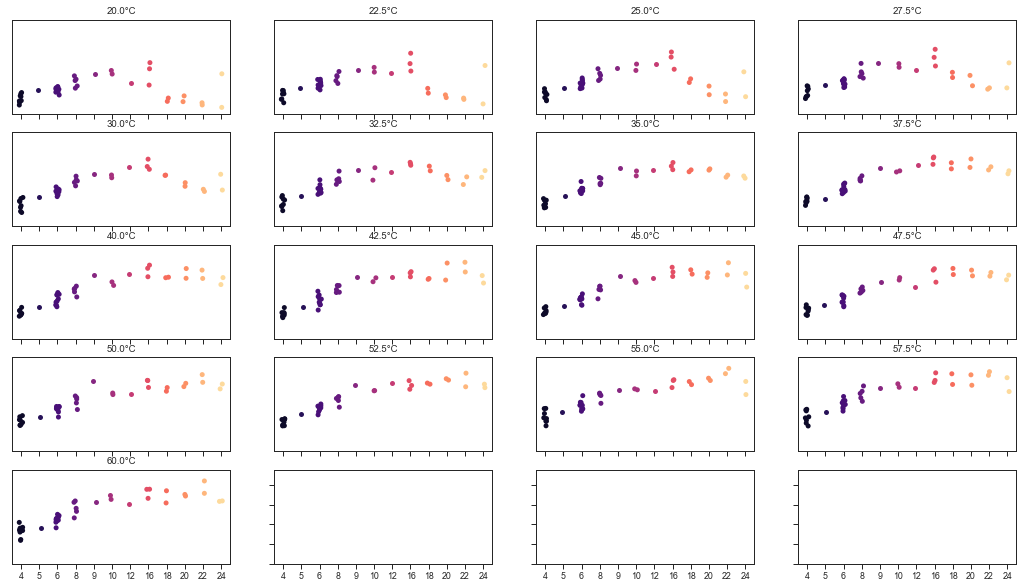

In [68]:
fig, ax = plt.subplots(5,4,figsize=(18,10), sharex=True, sharey=True)
ax = ax.flatten()
for i, cond in enumerate(conds):
    sns.stripplot(data=repeat_series, x='length', y=cond, palette='magma', ax=ax[i])
    ax[i].set_title(cond.split('_')[1] + '°C')
    ax[i].set_ylim([0, 1.2])
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel('')

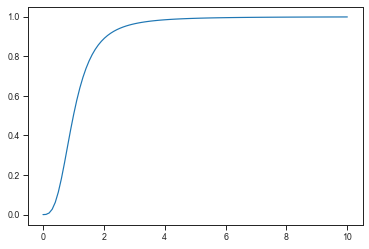

In [71]:
x = np.linspace(0,10,100)
y = 1 / (1 + 1 / (x**3))
plt.plot(x, y)

0.939975087513748

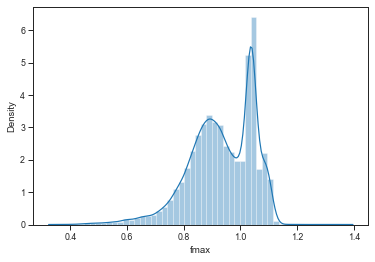

In [78]:
sns.distplot(arr.fmax)
arr.fmax.median()

-0.046718834117705756

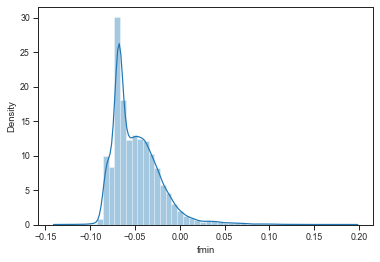

In [76]:
sns.distplot(arr.fmin)
np.percentile(arr.fmin, 60)